In [1]:
from data_processing import SDTDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
from model import UNet

In [2]:
# load model from checkpoint
modelpath = '/localscratch/dl4mia-project-segmentation/logs/model.pth'
model = UNet(
        depth=4,
        in_channels=1,
        out_channels=1,
        final_activation="Tanh",
        num_fmaps=16,
        fmap_inc_factor=3,
        downsample_factor=2,
        padding="same",
        upsample_mode="nearest",
    )
checkpoint = torch.load(modelpath)
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cuda')
model.eval()

UNet(
  (left_convs): ModuleList(
    (0): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(48, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(144, 432, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(432

In [3]:
transform = transforms.Compose(
        [
            transforms.CenterCrop((128, 128))
        ]
    )
train_data = SDTDataset(train=True, transform=transform)
# train_loader = DataLoader(train_data, batch_size=1, shuffle=False)
val_data = SDTDataset(train=False, transform=transform, return_mask=True)
# val_loader = DataLoader(val_data, batch_size=1, shuffle=False)

In [4]:
#retrieve image
idx = 50
image, mask, sdt = val_data[idx]
print(image.shape)
image = image.to('cuda')

#generate prediction from neural network
pred = model(image[np.newaxis, ...])

#removes redundant dimensions I think?
image = np.squeeze(image.cpu())
gt_labels = np.squeeze(mask.cpu().numpy())
gt_sdt = np.squeeze(sdt.cpu().numpy())
pred = np.squeeze(pred.cpu().detach().numpy())

torch.Size([1, 128, 128])


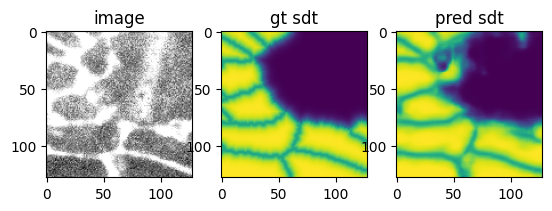

In [5]:
#visualize the outputs
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(gt_sdt, cmap='viridis')
ax[1].set_title('gt sdt')
ax[2].imshow(pred, cmap='viridis')
ax[2].set_title('pred sdt')
plt.show()

In [6]:
# perform a watershed on the predicted sdt mask
from model_evaluation import watershed_from_boundary_distance, get_inner_mask
from skimage.filters import threshold_otsu

# Do watershed and compare to gt mask
threshold = threshold_otsu(pred)

# Get inner mask
inner_mask = get_inner_mask(pred, threshold=threshold)

# Get the segmentation
seg = watershed_from_boundary_distance(pred, inner_mask, min_seed_distance=20)

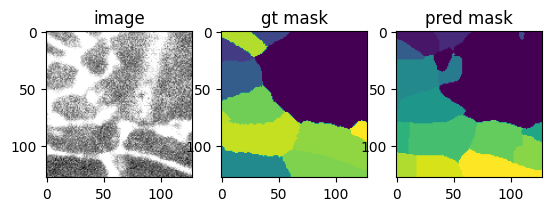

In [7]:
#visualize the outputs
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(gt_labels, cmap='viridis')
ax[1].set_title('gt mask')
ax[2].imshow(seg, cmap='viridis')
ax[2].set_title('pred mask')
plt.show()

In [8]:
# get some metrics to compare
from model_evaluation import evaluate
from sklearn.metrics import mean_squared_error
metrics = dict()
metrics['precision_list'], metrics['recall_list'], metrics['accuracy_list'], metrics['iou_list'], metrics['mse_list'] = [], [], [], [], []
precision, recall, accuracy, iou = evaluate(gt_labels, seg)
metrics['precision_list'].append(precision)
metrics['recall_list'].append(recall)
metrics['accuracy_list'].append(accuracy)
metrics['iou_list'].append(iou)
metrics['mse_list'].append(mean_squared_error(pred.flatten(), gt_sdt.flatten()))

In [13]:
print(f"Precision: {metrics['precision_list'][0]}")
print(f"Recall: {metrics['recall_list'][0]}")
print(f"Accuracy: {metrics['accuracy_list'][0]}")
print(f"MSE: {metrics['mse_list'][0]}")
print(f"Mean IOU: {np.mean(metrics['iou_list'])}")
print(f"Mean TP IOU: {np.mean(metrics['iou_list'][0][metrics['iou_list'][0] > 0.5])}")

Precision: 0.6666666666666666
Recall: 0.7692307692307693
Accuracy: 0.5555555555555556
MSE: 0.08262117952108383
Mean IOU: 0.5422018766403198
Mean TP IOU: 0.7371120452880859
